In [1]:
import os
os.environ["BRASA_DATA_PATH"] = "D:\\brasa"

import sys
sys.path.append('..')

from datetime import datetime

import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc

from bizdays import Calendar

from brasa.parsers.b3.futures_settlement_prices import maturity2date
import brasa

In [2]:
man = brasa.CacheManager()
cal = Calendar.load("ANBIMA")

In [3]:
ds_bvbg028_futures = brasa.get_dataset("b3-bvbg028-future_contracts")

In [4]:
ds_bvbg028_futures.schema

creation_date: timestamp[us]
refdate: timestamp[us]
security_id: int64
security_proprietary: int64
security_market: string
instrument_asset: string
instrument_asset_description: string
instrument_market: int64
instrument_segment: int64
instrument_description: string
security_category: int64
maturity_date: timestamp[us]
symbol: string
expiration_code: string
trading_start_date: timestamp[us]
trading_end_date: timestamp[us]
value_type_code: int64
cfi_code: string
delivery_type: int64
payment_type: int64
trading_currency: string
withdrawal_days: int64
working_days: int64
calendar_days: int64
instrument_type: string
isin: string
contract_multiplier: double
asset_settlement_indicator: double
allocation_lot_size: double
underlying_security_id: double
underlying_security_proprietary: double
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 4362

In [5]:
cols = [
    'symbol',
    'security_id',
    'security_proprietary',
    'security_market',
    'security_category',
    'instrument_asset',
    'expiration_code',
    'instrument_asset_description',
    'instrument_market',
    'instrument_segment',
    'instrument_description',
    'maturity_date',
    'trading_start_date',
    'trading_end_date',
    'value_type_code',
    'delivery_type',
    'payment_type',
    'trading_currency',
    'isin',
    'contract_multiplier',
    'asset_settlement_indicator',
    'allocation_lot_size',
    'underlying_security_id',
    'underlying_security_proprietary'
]

df_bvbg028_futures = ds_bvbg028_futures.to_table(columns=cols).to_pandas().drop_duplicates()
tb_bvbg028_futures = pa.Table.from_pandas(df_bvbg028_futures)
ds.write_dataset(tb_bvbg028_futures, man.db_path("b3-futures-register"), format="parquet", existing_data_behavior="overwrite_or_ignore")

In [6]:
symbols = tb_bvbg028_futures.filter(pc.field("instrument_asset") == "WIN").column("symbol").unique()
tb_futures_win = brasa.get_dataset("b3-futures-settlement-prices").filter(pc.field("symbol").isin(symbols)).to_table()
df_futures_win = tb_futures_win.to_pandas()
df_futures_win = df_futures_win.merge(df_bvbg028_futures[["symbol", "maturity_date"]].drop_duplicates(), on="symbol", how="left")
df_futures_win
df_futures_win["business_days"] = cal.bizdays(df_futures_win['refdate'], cal.following(df_futures_win["maturity_date"]))
df_futures_win.sort_values(["refdate", "maturity_date"], inplace=True)
df_futures_win = df_futures_win[["refdate", "symbol", "maturity_date", "settlement_price", "business_days"]]
tb_futures_win = pa.Table.from_pandas(df_futures_win)
ds.write_dataset(tb_futures_win, man.db_path("b3-futures-win"), format="parquet", existing_data_behavior="overwrite_or_ignore")

In [10]:
first = df_futures_win.groupby("refdate").nth(0)
second = df_futures_win.groupby("refdate").nth(1)
merged = first.merge(second, on="refdate", how="left")
idx = merged["business_days_x"] == 0
merged.loc[idx, "symbol_x"] = merged.loc[idx, "symbol_y"]
merged.loc[idx, "maturity_date_x"] = merged.loc[idx, "maturity_date_y"]
merged.loc[idx, "settlement_price_x"] = merged.loc[idx, "settlement_price_y"]
merged.loc[idx, "business_days_x"] = merged.loc[idx, "business_days_y"]
merged["ref"] = merged["symbol_x"]
merged["symbol"] = "WINT01"
merged.rename(columns={"maturity_date_x": "maturity_date", "settlement_price_x": "settlement_price", "business_days_x": "business_days"}, inplace=True)
first_contracts = merged[["refdate", "symbol", "maturity_date", "settlement_price", "business_days", "ref"]]

tb_win_first_contracts = pa.Table.from_pandas(first_contracts)
ds.write_dataset(tb_win_first_contracts, man.db_path("b3-futures-win-first-generic"), format="parquet", existing_data_behavior="overwrite_or_ignore")

<Axes: xlabel='refdate'>

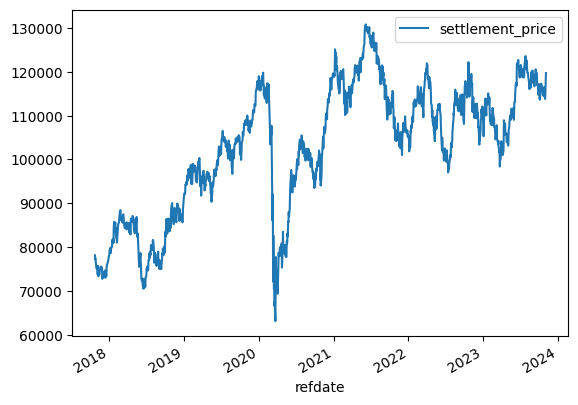

In [11]:
first_contracts.plot(x="refdate", y="settlement_price")

In [12]:
first_contracts.tail(20)

,refdate,symbol,maturity_date,settlement_price,business_days,ref
1471,2023-10-05,WINT01,2023-10-18,113628.0,8,WINV23
1472,2023-10-06,WINT01,2023-10-18,114476.0,7,WINV23
1473,2023-10-09,WINT01,2023-10-18,115440.0,6,WINV23
1474,2023-10-10,WINT01,2023-10-18,116986.0,5,WINV23
1475,2023-10-11,WINT01,2023-10-18,117293.0,4,WINV23
1476,2023-10-13,WINT01,2023-10-18,115762.0,3,WINV23
1477,2023-10-16,WINT01,2023-10-18,116646.0,2,WINV23
1478,2023-10-17,WINT01,2023-10-18,115919.0,1,WINV23
1479,2023-10-18,WINT01,2023-12-13,115811.0,38,WINZ23
1480,2023-10-19,WINT01,2023-12-13,115763.0,37,WINZ23


In [13]:
ds_equities = brasa.get_dataset("b3-bvbg028-equities")\
    .filter(pc.field("instrument_market") == 10)\
    .filter(pc.field("instrument_segment") == 1)\
    .filter(pc.field("instrument_asset") != "TAXA")\
    .filter(pc.field("trading_start_date") != datetime(9999, 12, 31))\
    .filter(pc.field("security_category").isin(pa.array([1, 11, 6, 21, 3, 13])))
ds_marketdata = brasa.get_dataset("b3-bvbg086")

In [14]:
ds_equities.schema

creation_date: timestamp[us]
refdate: timestamp[us]
security_id: int64
security_proprietary: int64
security_market: string
instrument_asset: string
instrument_asset_description: string
instrument_market: int64
instrument_segment: int64
instrument_description: string
security_category: int64
isin: string
distribution_id: int64
cfi_code: string
specification_code: string
corporation_name: string
symbol: string
payment_type: int64
allocation_lot_size: int64
price_factor: int64
trading_start_date: timestamp[us]
trading_end_date: timestamp[us]
corporate_action_start_date: timestamp[us]
ex_distribution_number: int64
custody_treatment_type: double
trading_currency: string
market_capitalisation: int64
close: double
open: double
days_to_settlement: int64
right_issue_price: double
instrument_type: string
governance_indicator: string
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 4605

In [15]:
cols = [
    "security_id",
    "security_proprietary",
    "security_market",
    "security_category",
    "instrument_asset",
    "instrument_asset_description",
    "instrument_market",
    "instrument_segment",
    "instrument_description",
    "isin",
    "distribution_id",
    "ex_distribution_number",
    "cfi_code",
    "specification_code",
    "corporation_name",
    "symbol",
    "payment_type",
    "allocation_lot_size",
    "price_factor",
    "trading_start_date",
    "trading_end_date",
    "corporate_action_start_date",
    "custody_treatment_type",
    "trading_currency",
    "market_capitalisation",
    "governance_indicator",
]

df_equities = ds_equities.to_table(columns=cols).to_pandas().drop_duplicates()
df_equities.shape

(72226, 26)

In [16]:
df_equities[["symbol", "security_category"]].drop_duplicates().security_category.value_counts()
# 1 11 6 21 3 13

security_category
1     1181
11     752
6      591
21      49
3       41
13      33
Name: count, dtype: int64

In [17]:
cols = [
    "refdate",
    "symbol",
    "trade_quantity",
    "volume",
    "traded_contracts",
    "oscillation_percentage",
]

df_marketdata = ds_marketdata.filter(pc.field("symbol").isin(df_equities["symbol"])).filter(~pc.is_null(pc.field("oscillation_percentage"))).to_table(columns=cols).to_pandas()
df_marketdata

,refdate,symbol,trade_quantity,volume,traded_contracts,oscillation_percentage
0,2018-01-02,IVVB11,270.0,4202309.00,45630.0,-1.52
1,2018-01-02,OSXB3,6.0,9948.00,1300.0,-0.78
2,2018-01-02,LLIS3,9.0,265062.00,8300.0,-2.46
3,2018-01-02,BRIN3,96.0,401695.00,32900.0,-1.88
4,2018-01-02,CGRA4,58.0,434014.00,15800.0,-0.16
...,...,...,...,...,...,...
1281041,2023-11-03,B1IL34,10.0,25010.13,1746.0,9.59
1281042,2023-11-03,BCWV39,1.0,330.40,7.0,-0.73
1281043,2023-11-03,CEDO4,12.0,201348.00,13200.0,0.32
1281044,2023-11-03,META11,10.0,2967.67,131.0,-0.83


In [18]:
import numpy as np


df_marketdata["pct_return"] = df_marketdata["oscillation_percentage"] / 100
df_marketdata["log_return"] = np.exp(df_marketdata["pct_return"]) - 1

c:\Users\wilso\AppData\Local\pypoetry\Cache\virtualenvs\brasa-iv4UAxlw-py3.10\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
df_marketdata.sort_values(["refdate", "symbol"], inplace=True)

<Axes: xlabel='refdate'>

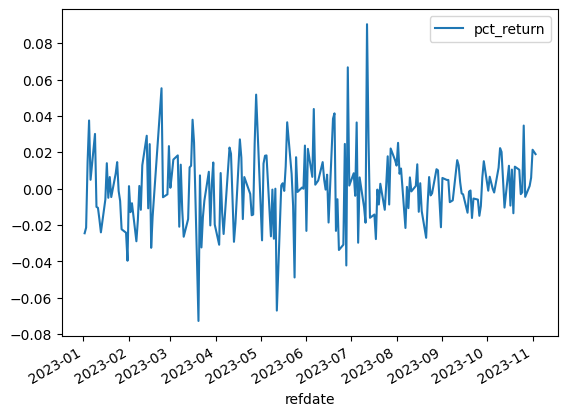

In [20]:
df_marketdata.query("symbol == 'JBSS3'").query("refdate > '2023-01-01'").plot(x="refdate", y="pct_return")

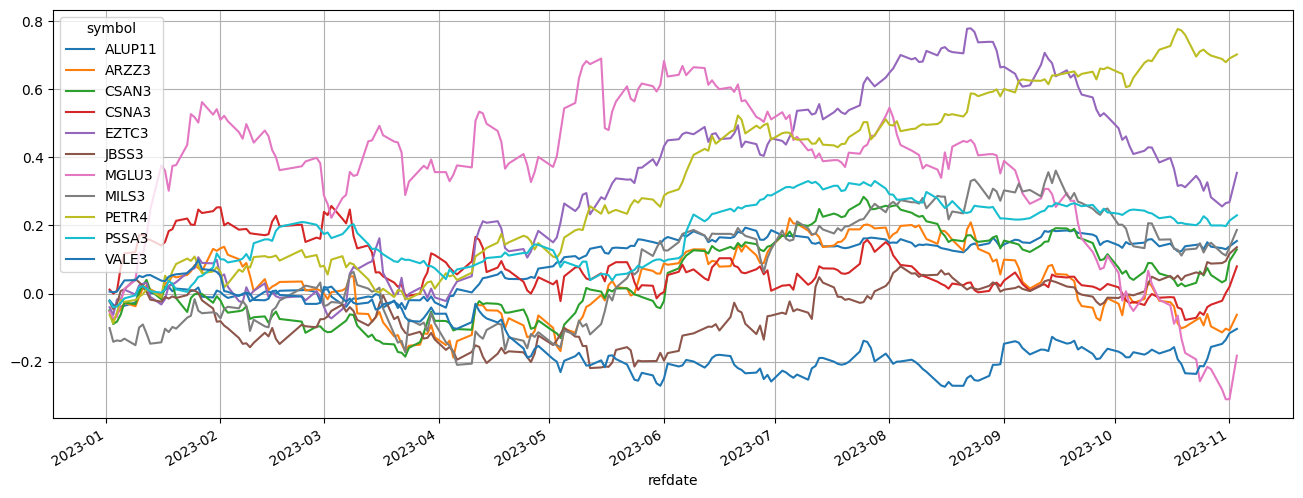

In [21]:
symbols = ["VALE3", "PETR4", "JBSS3", "EZTC3", "ARZZ3", "MGLU3", "PSSA3", "MILS3", "CSAN3", "CSNA3", "ALUP11"]
df_marketdata[df_marketdata.symbol.isin(symbols)]\
    .query("refdate > '2023-01-01'").pivot(columns="symbol", index="refdate", values="log_return").cumsum().plot(figsize=(16, 6)).grid()

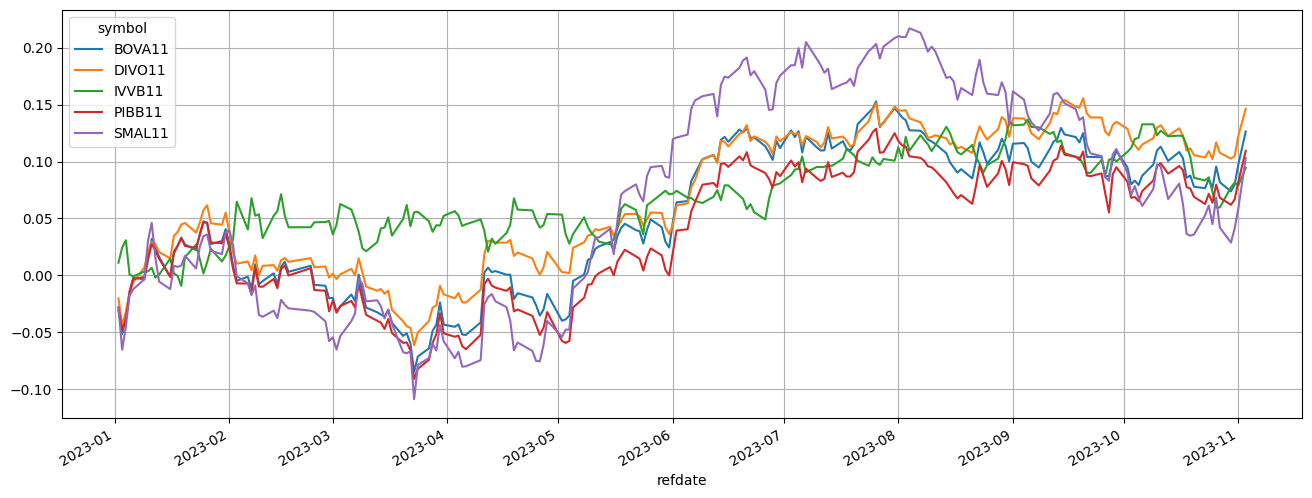

In [22]:
symbols = ["PIBB11", "BOVA11", "IVVB11", "DIVO11", "SMAL11", ""]
df_marketdata[df_marketdata.symbol.isin(symbols)]\
    .query("refdate > '2023-01-01'").pivot(columns="symbol", index="refdate", values="log_return").cumsum().plot(figsize=(16, 6)).grid()

In [23]:
tb_equities = pa.Table.from_pandas(df_equities)
ds.write_dataset(tb_equities, man.db_path("b3-equities-register"), format="parquet", existing_data_behavior="overwrite_or_ignore")
tb_marketdata = pa.Table.from_pandas(df_marketdata)
ds.write_dataset(tb_marketdata, man.db_path("b3-equities-marketdata"), format="parquet", existing_data_behavior="overwrite_or_ignore")

In [24]:
ds_index = brasa.get_dataset("b3-bvbg087-indexes_info")
ds_index.schema

cols = [
    "refdate",
    "symbol",
    "security_id",
    "security_proprietary",
    "security_market",
    "asset_desc",
    "settlement_price",
    "open_price",
    "min_price",
    "max_price",
    "average_price",
    "close_price",
    "last_price",
    "oscillation_val",
    "rising_shares_number",
    "falling_shares_number",
    "stable_shares_number",
]

df_index = ds_index.to_table(columns=cols).to_pandas()
df_index

,refdate,symbol,security_id,security_proprietary,security_market,asset_desc,settlement_price,open_price,min_price,max_price,average_price,close_price,last_price,oscillation_val,rising_shares_number,falling_shares_number,stable_shares_number
0,2016-05-05,IFIX,4011052,8,BVMF,IND FDO IMOB,1551.7525,1547.02,1543.68,1554.41,1550.98,1552.09,1552.09,0.003257,28,31,11
1,2016-05-05,IVBX,4011110,8,BVMF,IVBX2,7863.9816,7955.01,7837.43,8003.80,7892.65,7855.13,7855.13,-0.012476,15,34,1
2,2016-05-05,IBXX,4010872,8,BVMF,IBRX BRASIL,21276.3836,21627.87,21139.58,21835.73,21419.57,21275.50,21275.50,-0.016284,24,74,2
3,2016-05-05,ICON,4010971,8,BVMF,ICONSUMO,2626.1435,2667.45,2616.89,2679.61,2636.69,2626.47,2626.47,-0.015224,10,22,1
4,2016-05-05,IBRA,4010963,8,BVMF,IBRASIL,1969.0053,2001.31,1956.52,2020.23,1982.14,1969.00,1969.00,-0.016140,31,83,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46116,2023-11-03,SMLL,10018394,8,BVMF,SMALL CAP,2070.0000,1983.68,1983.68,2081.01,2060.03,2073.82,2073.82,0.045400,110,4,1
46117,2023-11-03,IBRA,10018384,8,BVMF,IBRASIL,4659.0000,4530.58,4530.58,4669.76,4646.27,4657.14,4657.14,0.027900,172,5,1
46118,2023-11-03,ISEE,10018391,8,BVMF,ISUSTENTABIL,3253.0000,3138.84,3138.79,3262.13,3241.17,3253.66,3253.66,0.036700,66,1,0
46119,2023-11-03,ITAG,10018393,8,BVMF,ITAG ALONG,26285.0000,25547.42,25547.42,26343.09,26212.14,26275.99,26275.99,0.028500,224,11,3


In [25]:
df_index["pct_return"] = df_index["oscillation_val"]
df_index["log_return"] = np.exp(df_index["pct_return"]) - 1

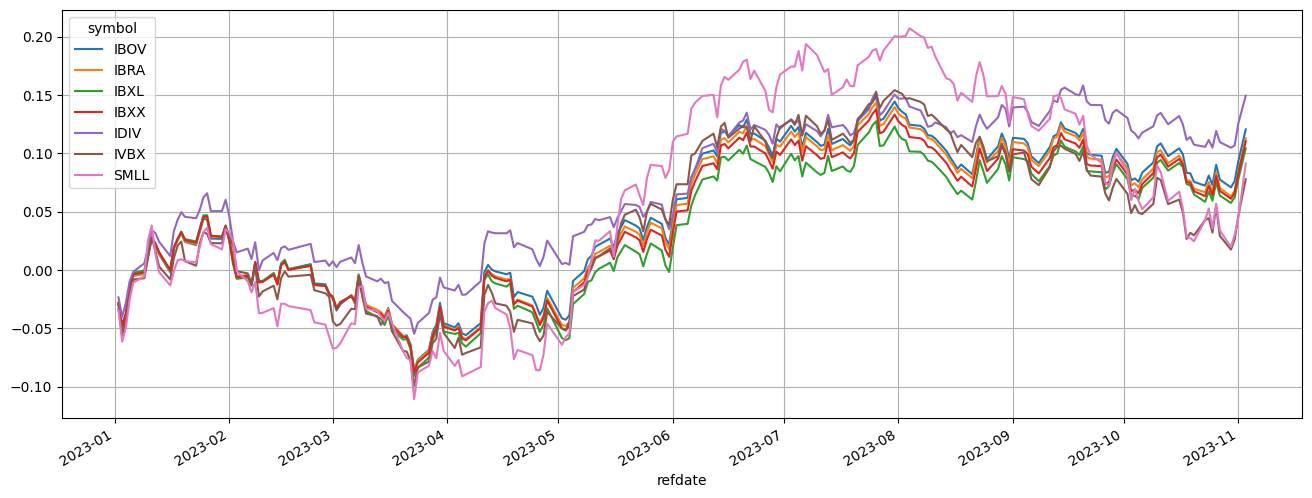

In [26]:
symbols = ["IBXX", "IBOV", "IBXL", "SMLL", "IDIV", "IVBX", "IBRA"]
df_index[df_index.symbol.isin(symbols)]\
    .query("refdate > '2023-01-01'").pivot(columns="symbol", index="refdate", values="log_return").cumsum().plot(figsize=(16, 6)).grid()

In [27]:
tb_index = pa.Table.from_pandas(df_index)
ds.write_dataset(tb_index, man.db_path("b3-indexes-marketdata"), format="parquet", existing_data_behavior="overwrite_or_ignore")